# Fase 4 — MIVA: Análise Unificada de Amplificação de Viés
---

**Metodologia para Identificação de Viés Amplificado (MIVA)**

Este notebook consolida os resultados das fases 2 (empírica) e 3 (sintética) em uma análise unificada, seguindo o fluxograma MIVA:

1. **Módulo I** — Consistência Preliminar (κ_inicial dos anotadores)
2. **Módulo II** — Treinamento dos Modelos (κ por classificador)
3. **Módulo III** — Avaliação de Divergência entre Modelos (κ_modelos)
4. **Módulo IV** — Comparação e Detecção (Δκ = κ_inicial − κ_modelos)
5. **Objetivo Final** — Quantificação da Amplificação de Viés (Relatório de Severidade)

#### Inputs necessários
* `resultados_empiricos/metricas_modelos_pareados.csv`
* `resultados_sinteticos/metricas_sinteticas_consolidadas.csv`

#### Outputs gerados (pasta `resultados_gerais/`)
* `resumo_miva_empirico.csv`
* `resumo_miva_sintetico.csv`
* `resumo_miva_unificado.csv`
* Gráficos comparativos (PNG)

In [1]:
# Importações

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

# Configuração global de gráficos
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'font.size': 11,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

SEED = 42
np.random.seed(SEED)

In [4]:
# =============================================================================
# CONFIGURAÇÃO DE CAMINHOS E PARÂMETROS
# =============================================================================

# Caminhos de entrada
PATH_EMPIRICO = Path('data/resultados_empiricos/metricas_modelos_pareados.csv')
PATH_SINTETICO = Path('data/resultados_sinteticos/metricas_sinteticas_consolidadas.csv')

# Caminho de saída
PATH_SAIDA = Path('data/resultados_gerais')
PATH_SAIDA.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------------
# κ_inicial dos anotadores reais (Fase 2 - Dados Empíricos)
# -------------------------------------------------------------------------
# TODO: Substituir pelo valor vindo diretamente do CSV quando disponível.
#       Ex: kappa_anotadores_empirico = df_empirico.loc[
#           df_empirico['modelo'] == 'Anotadores', 'kappa_mean'].values[0]
KAPPA_ANOTADORES_EMPIRICO = 0.7652

# Lista de modelos (consistente entre fases 2 e 3)
MODELOS = ['SVM', 'NB', 'RF', 'LR']

print(f"κ_inicial (anotadores reais): {KAPPA_ANOTADORES_EMPIRICO}")
print(f"Modelos avaliados: {MODELOS}")
print(f"Pasta de saída: {PATH_SAIDA}")

κ_inicial (anotadores reais): 0.7652
Modelos avaliados: ['SVM', 'NB', 'RF', 'LR']
Pasta de saída: data\resultados_gerais


## 1. Carregamento dos Dados
---

In [5]:
# =============================================================================
# CARREGAMENTO — FASE 2 (Empírico)
# =============================================================================

df_empirico = pd.read_csv(PATH_EMPIRICO)

print("="*80)
print("FASE 2 — RESULTADOS EMPÍRICOS")
print("="*80)
print(f"Arquivo: {PATH_EMPIRICO}")
print(f"Modelos: {df_empirico['modelo'].tolist()}")
print(f"\nColunas: {df_empirico.columns.tolist()}")
print()
print(df_empirico[['modelo', 'kappa_mean', 'kappa_std', 'kappa_weighted_mean',
                    'concordancia_mean']].to_string(index=False))

FASE 2 — RESULTADOS EMPÍRICOS
Arquivo: data\resultados_empiricos\metricas_modelos_pareados.csv
Modelos: ['SVM', 'NB', 'RF', 'LR']

Colunas: ['modelo', 'kappa_mean', 'kappa_std', 'kappa_weighted_mean', 'kappa_weighted_std', 'concordancia_mean', 'concordancia_std', 'acc_masculino_mean', 'acc_masculino_std', 'acc_feminino_mean', 'acc_feminino_std', 'f1_masculino_mean', 'f1_feminino_mean']

modelo  kappa_mean  kappa_std  kappa_weighted_mean  concordancia_mean
   SVM    0.464724   0.027514             0.514875           0.664185
    NB    0.486187   0.026700             0.538913           0.682353
    RF    0.437771   0.033910             0.485981           0.664994
    LR    0.498630   0.043343             0.549604           0.683183


In [6]:
# =============================================================================
# CARREGAMENTO — FASE 3 (Sintético)
# =============================================================================

df_sintetico = pd.read_csv(PATH_SINTETICO)

print("="*80)
print("FASE 3 — RESULTADOS SINTÉTICOS")
print("="*80)
print(f"Arquivo: {PATH_SINTETICO}")
print(f"Datasets: {df_sintetico['dataset'].unique().tolist()}")
print(f"Fontes: {df_sintetico['fonte'].unique().tolist()}")
print(f"Concordâncias-alvo: {sorted(df_sintetico['concordancia_alvo'].unique(), reverse=True)}")
print(f"\nTotal de linhas: {len(df_sintetico)}")
print()

# Visão resumida: Anotadores por dataset
df_anot_sint = df_sintetico[df_sintetico['fonte'] == 'Anotadores'][['dataset', 'concordancia_alvo', 'cohen_kappa']]
print("κ dos Anotadores Sintéticos (por dataset):")
print(df_anot_sint.to_string(index=False))

FASE 3 — RESULTADOS SINTÉTICOS
Arquivo: data\resultados_sinteticos\metricas_sinteticas_consolidadas.csv
Datasets: ['SynSA-99', 'SynSA-97', 'SynSA-95', 'SynSA-90', 'SynSA-85', 'SynSA-80', 'SynSA-75', 'SynSA-70', 'SynSA-65', 'SynSA-60', 'SynSA-55', 'SynSA-50']
Fontes: ['Anotadores', 'SVM', 'NB', 'RF', 'LR']
Concordâncias-alvo: [np.int64(99), np.int64(97), np.int64(95), np.int64(90), np.int64(85), np.int64(80), np.int64(75), np.int64(70), np.int64(65), np.int64(60), np.int64(55), np.int64(50)]

Total de linhas: 60

κ dos Anotadores Sintéticos (por dataset):
 dataset  concordancia_alvo  cohen_kappa
SynSA-99                 99     0.984985
SynSA-97                 97     0.954955
SynSA-95                 95     0.924925
SynSA-90                 90     0.849849
SynSA-85                 85     0.774775
SynSA-80                 80     0.699699
SynSA-75                 75     0.624623
SynSA-70                 70     0.549550
SynSA-65                 65     0.474473
SynSA-60                 60  

## 2. Módulo IV — Cálculo de Δκ e Classificação de Severidade
---

Conforme o fluxograma MIVA:

$$\Delta\kappa = \kappa_{\text{inicial}} - \kappa_{\text{modelos}}$$

**Escala de Severidade:**

| Δκ | Severidade |
|---|---|
| Δκ ≤ 0.05 | Ausente |
| 0.05 < Δκ ≤ 0.15 | Leve |
| 0.15 < Δκ ≤ 0.30 | Moderada |
| Δκ > 0.30 | Severa |

In [7]:
# =============================================================================
# FUNÇÃO DE CLASSIFICAÇÃO DE SEVERIDADE
# =============================================================================

def classificar_severidade(delta_kappa):
    """
    Classifica a severidade da amplificação de viés com base no Δκ.
    
    Parâmetros:
        delta_kappa (float): diferença κ_inicial - κ_modelos
    
    Retorna:
        str: nível de severidade
    """
    if delta_kappa <= 0.05:
        return 'Ausente'
    elif delta_kappa <= 0.15:
        return 'Leve'
    elif delta_kappa <= 0.30:
        return 'Moderada'
    else:
        return 'Severa'


def cor_severidade(severidade):
    """Retorna cor associada ao nível de severidade."""
    cores = {
        'Ausente': '#2ecc71',
        'Leve': '#f1c40f',
        'Moderada': '#e67e22',
        'Severa': '#e74c3c'
    }
    return cores.get(severidade, '#95a5a6')


print("Função de severidade definida.")
print("Exemplos:")
for d in [0.02, 0.10, 0.25, 0.45]:
    print(f"  Δκ = {d:.2f} → {classificar_severidade(d)}")

Função de severidade definida.
Exemplos:
  Δκ = 0.02 → Ausente
  Δκ = 0.10 → Leve
  Δκ = 0.25 → Moderada
  Δκ = 0.45 → Severa


### 2.1 MIVA — Dados Empíricos (Fase 2)

In [8]:
# =============================================================================
# MIVA — DADOS EMPÍRICOS
# =============================================================================

kappa_inicial_emp = KAPPA_ANOTADORES_EMPIRICO

registros_emp = []
for _, row in df_empirico.iterrows():
    modelo = row['modelo']
    kappa_modelo = row['kappa_mean']
    delta_k = kappa_inicial_emp - kappa_modelo
    severidade = classificar_severidade(delta_k)
    
    registros_emp.append({
        'fonte': 'Empírico (MQD-1465)',
        'dataset': 'MQD-1209-MF',
        'modelo': modelo,
        'kappa_inicial': kappa_inicial_emp,
        'kappa_modelos': kappa_modelo,
        'kappa_modelos_std': row['kappa_std'],
        'delta_kappa': delta_k,
        'severidade': severidade,
        'concordancia_mean': row['concordancia_mean'],
        'kappa_weighted_mean': row['kappa_weighted_mean']
    })

df_miva_emp = pd.DataFrame(registros_emp)

print("="*80)
print("MIVA — RESULTADOS EMPÍRICOS")
print("="*80)
print(f"κ_inicial (Anotadores): {kappa_inicial_emp}")
print()
print(df_miva_emp[['modelo', 'kappa_inicial', 'kappa_modelos', 'delta_kappa',
                    'severidade']].to_string(index=False))

# Salvar
output_emp = PATH_SAIDA / 'resumo_miva_empirico.csv'
df_miva_emp.to_csv(output_emp, index=False)
print(f"\n✔ Salvo em: {output_emp}")

MIVA — RESULTADOS EMPÍRICOS
κ_inicial (Anotadores): 0.7652

modelo  kappa_inicial  kappa_modelos  delta_kappa severidade
   SVM         0.7652       0.464724     0.300476     Severa
    NB         0.7652       0.486187     0.279013   Moderada
    RF         0.7652       0.437771     0.327429     Severa
    LR         0.7652       0.498630     0.266570   Moderada

✔ Salvo em: data\resultados_gerais\resumo_miva_empirico.csv


### 2.2 MIVA — Dados Sintéticos (Fase 3)

In [9]:
# =============================================================================
# MIVA — DADOS SINTÉTICOS
# =============================================================================

# Separar anotadores e modelos
df_anot = df_sintetico[df_sintetico['fonte'] == 'Anotadores'].copy()
df_modelos = df_sintetico[df_sintetico['fonte'] != 'Anotadores'].copy()

# Criar dicionário de κ_inicial por dataset
kappa_inicial_por_dataset = df_anot.set_index('dataset')['cohen_kappa'].to_dict()

registros_sint = []
for _, row in df_modelos.iterrows():
    ds = row['dataset']
    modelo = row['fonte']
    kappa_inicial = kappa_inicial_por_dataset[ds]
    kappa_modelo = row['cohen_kappa']
    delta_k = kappa_inicial - kappa_modelo
    severidade = classificar_severidade(delta_k)
    
    registros_sint.append({
        'fonte': 'Sintético',
        'dataset': ds,
        'concordancia_alvo': row['concordancia_alvo'],
        'modelo': modelo,
        'kappa_inicial': kappa_inicial,
        'kappa_modelos': kappa_modelo,
        'delta_kappa': delta_k,
        'severidade': severidade,
        'weighted_kappa': row['weighted_kappa'],
        'cramers_v': row['cramers_v'],
        'chi2_stat': row['chi2_stat'],
        'p_value': row['p_value']
    })

df_miva_sint = pd.DataFrame(registros_sint)

print("="*80)
print("MIVA — RESULTADOS SINTÉTICOS")
print("="*80)
print(f"Datasets avaliados: {df_miva_sint['dataset'].nunique()}")
print(f"Total de comparações (modelo × dataset): {len(df_miva_sint)}")
print()

# Tabela-resumo pivotada: Δκ por modelo e dataset
pivot_delta = df_miva_sint.pivot_table(
    index='dataset', columns='modelo', values='delta_kappa', aggfunc='first'
)[MODELOS]

# Reordenar por concordância decrescente
ordem_ds = df_miva_sint.drop_duplicates('dataset').sort_values(
    'concordancia_alvo', ascending=False)['dataset'].tolist()
pivot_delta = pivot_delta.reindex(ordem_ds)

print("Δκ por modelo e dataset sintético:")
print(pivot_delta.round(4).to_string())

# Salvar
output_sint = PATH_SAIDA / 'resumo_miva_sintetico.csv'
df_miva_sint.to_csv(output_sint, index=False)
print(f"\n✔ Salvo em: {output_sint}")

MIVA — RESULTADOS SINTÉTICOS
Datasets avaliados: 12
Total de comparações (modelo × dataset): 48

Δκ por modelo e dataset sintético:
modelo       SVM      NB      RF      LR
dataset                                 
SynSA-99  0.3496  0.3375  0.7347  0.3109
SynSA-97  0.3974  0.4279  0.7527  0.4026
SynSA-95  0.4546  0.4427  0.7628  0.4130
SynSA-90  0.4557  0.4602  0.6927  0.4310
SynSA-85  0.3697  0.3619  0.5961  0.3692
SynSA-80  0.3414  0.3525  0.5474  0.3262
SynSA-75  0.3289  0.3318  0.4831  0.3358
SynSA-70  0.2778  0.2726  0.4447  0.2913
SynSA-65  0.2272  0.2557  0.4007  0.2247
SynSA-60  0.2432  0.2535  0.3048  0.2146
SynSA-55  0.2015  0.2194  0.2772  0.1920
SynSA-50  0.1533  0.1465  0.1894  0.1252

✔ Salvo em: data\resultados_gerais\resumo_miva_sintetico.csv


### 2.3 Resumo Unificado

In [10]:
# =============================================================================
# RESUMO UNIFICADO (EMPÍRICO + SINTÉTICO)
# =============================================================================

# Normalizar colunas para concatenação
cols_unificado = ['fonte', 'dataset', 'modelo', 'kappa_inicial',
                  'kappa_modelos', 'delta_kappa', 'severidade']

df_unificado = pd.concat([
    df_miva_emp[cols_unificado],
    df_miva_sint[cols_unificado]
], ignore_index=True)

print("="*80)
print("RESUMO UNIFICADO MIVA")
print("="*80)
print(f"Total de comparações: {len(df_unificado)}")
print(f"\nDistribuição de severidade:")
print(df_unificado['severidade'].value_counts().to_string())

print(f"\nΔκ médio por modelo (todas as fontes):")
print(df_unificado.groupby('modelo')['delta_kappa'].agg(['mean', 'std', 'min', 'max']).round(4).to_string())

# Salvar
output_unif = PATH_SAIDA / 'resumo_miva_unificado.csv'
df_unificado.to_csv(output_unif, index=False)
print(f"\n✔ Salvo em: {output_unif}")

RESUMO UNIFICADO MIVA
Total de comparações: 52

Distribuição de severidade:
severidade
Severa      33
Moderada    17
Leve         2

Δκ médio por modelo (todas as fontes):
          mean     std     min     max
modelo                                
LR      0.3002  0.0930  0.1252  0.4310
NB      0.3186  0.0923  0.1465  0.4602
RF      0.5011  0.1966  0.1894  0.7628
SVM     0.3154  0.0934  0.1533  0.4557

✔ Salvo em: data\resultados_gerais\resumo_miva_unificado.csv


## 3. Visualizações
---

### 3.1 Gráfico 1 — Barras: Δκ por modelo (Dados Empíricos)

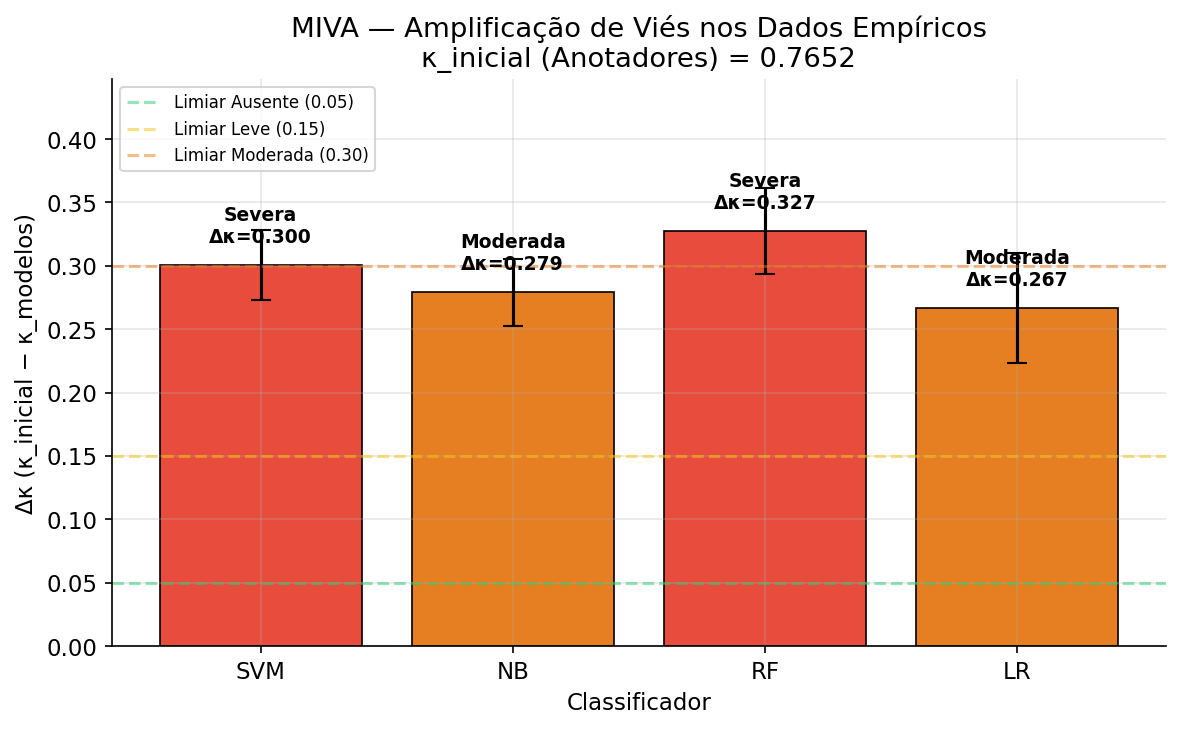

✔ Gráfico salvo: grafico1_delta_kappa_empirico.png


In [11]:
# =============================================================================
# GRÁFICO 1: Δκ por modelo — Dados Empíricos
# =============================================================================

fig, ax = plt.subplots(figsize=(8, 5))

cores_barras = [cor_severidade(s) for s in df_miva_emp['severidade']]

barras = ax.bar(
    df_miva_emp['modelo'],
    df_miva_emp['delta_kappa'],
    color=cores_barras,
    edgecolor='black',
    linewidth=0.8,
    yerr=df_miva_emp['kappa_modelos_std'],
    capsize=5
)

# Anotações de severidade
for bar, sev, dk in zip(barras, df_miva_emp['severidade'], df_miva_emp['delta_kappa']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.015,
            f'{sev}\nΔκ={dk:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Linhas de referência para faixas de severidade
ax.axhline(y=0.05, color='#2ecc71', linestyle='--', alpha=0.5, label='Limiar Ausente (0.05)')
ax.axhline(y=0.15, color='#f1c40f', linestyle='--', alpha=0.5, label='Limiar Leve (0.15)')
ax.axhline(y=0.30, color='#e67e22', linestyle='--', alpha=0.5, label='Limiar Moderada (0.30)')

ax.set_ylabel('Δκ (κ_inicial − κ_modelos)')
ax.set_xlabel('Classificador')
ax.set_title(f'MIVA — Amplificação de Viés nos Dados Empíricos\n'
             f'κ_inicial (Anotadores) = {KAPPA_ANOTADORES_EMPIRICO}')
ax.legend(loc='upper left', fontsize=8)
ax.set_ylim(0, max(df_miva_emp['delta_kappa']) + 0.12)

plt.tight_layout()
fig.savefig(PATH_SAIDA / 'grafico1_delta_kappa_empirico.png', bbox_inches='tight')
plt.show()
print("✔ Gráfico salvo: grafico1_delta_kappa_empirico.png")

### 3.2 Gráfico 2 — Curvas: κ_modelos vs κ_anotadores por concordância (Dados Sintéticos)

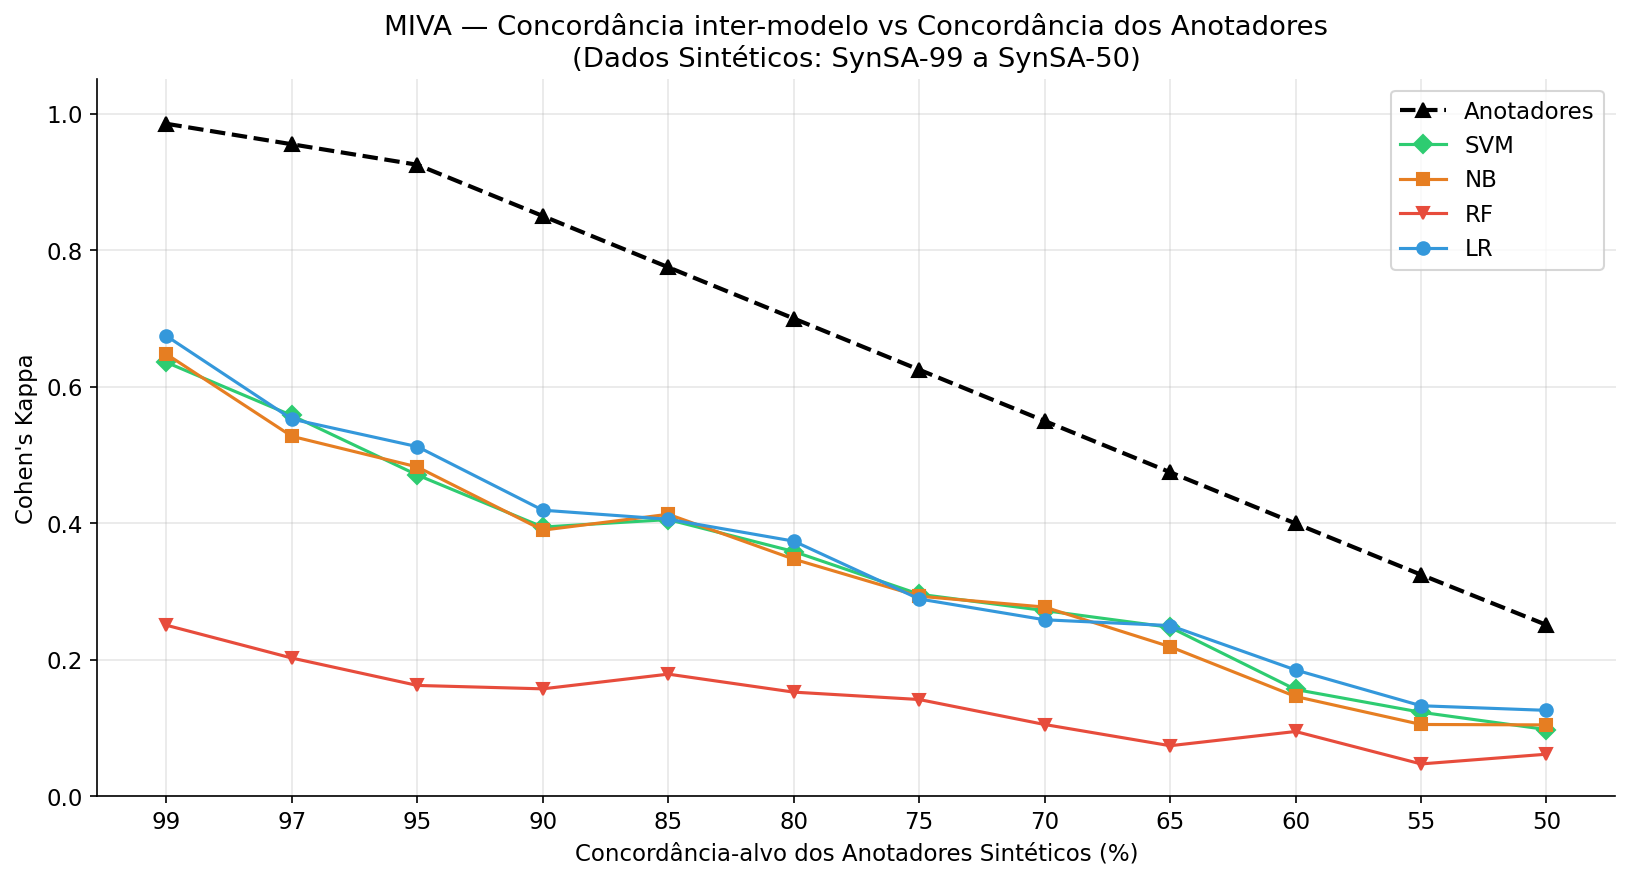

✔ Gráfico salvo: grafico2_curvas_kappa_sintetico.png


In [12]:
# =============================================================================
# GRÁFICO 2: Curvas κ — Sintético (estilo Fig. 2 do artigo)
# =============================================================================

fig, ax = plt.subplots(figsize=(11, 6))

# Eixo X: concordâncias-alvo em ordem decrescente
concordancias = sorted(df_miva_sint['concordancia_alvo'].unique(), reverse=True)

# Curva dos anotadores
kappas_anot = [kappa_inicial_por_dataset[f'SynSA-{c}'] for c in concordancias]
ax.plot(range(len(concordancias)), kappas_anot, 'k--^', linewidth=2,
        markersize=7, label='Anotadores', zorder=5)

# Curvas dos modelos
estilos = {'LR': ('o', '#3498db'), 'NB': ('s', '#e67e22'),
           'SVM': ('D', '#2ecc71'), 'RF': ('v', '#e74c3c')}

for modelo in MODELOS:
    df_mod = df_miva_sint[df_miva_sint['modelo'] == modelo].copy()
    df_mod = df_mod.sort_values('concordancia_alvo', ascending=False)
    marcador, cor = estilos[modelo]
    ax.plot(range(len(concordancias)), df_mod['kappa_modelos'].values,
            f'-{marcador}', color=cor, linewidth=1.5, markersize=6, label=modelo)

ax.set_xticks(range(len(concordancias)))
ax.set_xticklabels(concordancias)
ax.set_xlabel('Concordância-alvo dos Anotadores Sintéticos (%)')
ax.set_ylabel("Cohen's Kappa")
ax.set_title('MIVA — Concordância inter-modelo vs Concordância dos Anotadores\n'
             '(Dados Sintéticos: SynSA-99 a SynSA-50)')
ax.legend(loc='upper right')
ax.set_ylim(0, 1.05)

plt.tight_layout()
fig.savefig(PATH_SAIDA / 'grafico2_curvas_kappa_sintetico.png', bbox_inches='tight')
plt.show()
print("✔ Gráfico salvo: grafico2_curvas_kappa_sintetico.png")

### 3.3 Gráfico 3 — Heatmap: Severidade por modelo × dataset (Sintético)

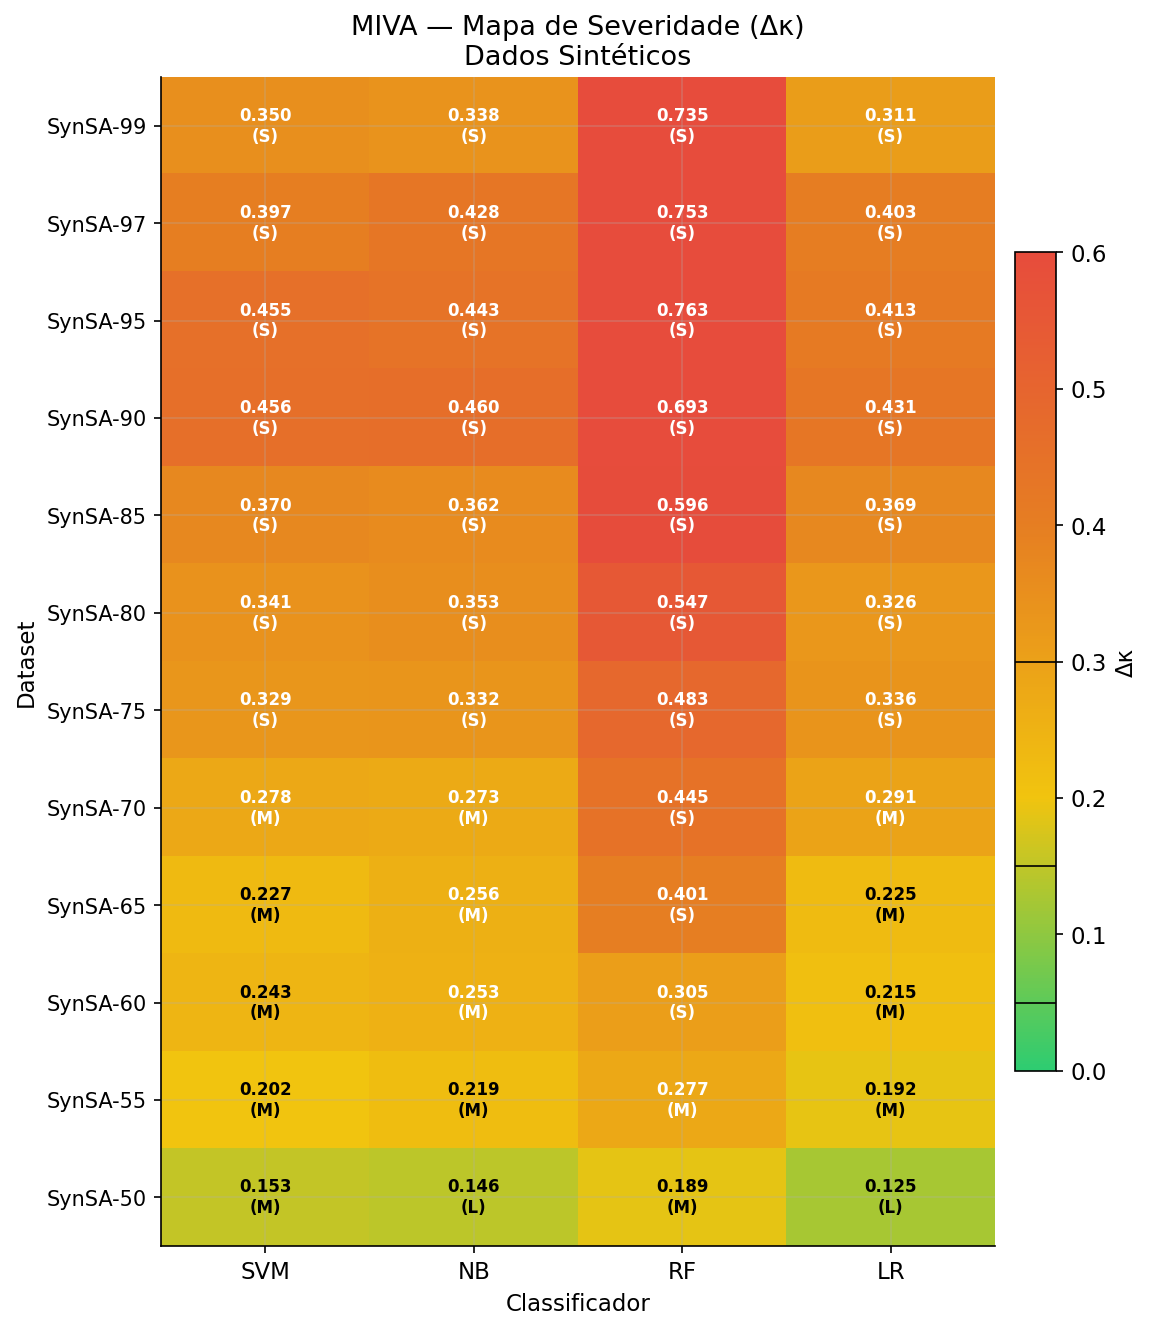

✔ Gráfico salvo: grafico3_heatmap_severidade_sintetico.png


In [13]:
# =============================================================================
# GRÁFICO 3: Heatmap de Δκ — Sintético
# =============================================================================

pivot_heatmap = df_miva_sint.pivot_table(
    index='dataset', columns='modelo', values='delta_kappa', aggfunc='first'
)[MODELOS].reindex(ordem_ds)

fig, ax = plt.subplots(figsize=(8, 9))

# Mapeamento manual de cores por valor
from matplotlib.colors import LinearSegmentedColormap
cores_mapa = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
cmap = LinearSegmentedColormap.from_list('severidade', cores_mapa, N=256)

im = ax.imshow(pivot_heatmap.values, cmap=cmap, aspect='auto',
               vmin=0, vmax=0.6)

# Rótulos
ax.set_xticks(range(len(MODELOS)))
ax.set_xticklabels(MODELOS, fontsize=11)
ax.set_yticks(range(len(ordem_ds)))
ax.set_yticklabels(ordem_ds, fontsize=10)

# Anotações dentro das células
for i in range(len(ordem_ds)):
    for j in range(len(MODELOS)):
        val = pivot_heatmap.values[i, j]
        sev = classificar_severidade(val)
        cor_texto = 'white' if val > 0.25 else 'black'
        ax.text(j, i, f'{val:.3f}\n({sev[0]})', ha='center', va='center',
                fontsize=8, fontweight='bold', color=cor_texto)

ax.set_title('MIVA — Mapa de Severidade (Δκ)\nDados Sintéticos', fontsize=13)
ax.set_xlabel('Classificador')
ax.set_ylabel('Dataset')

cbar = fig.colorbar(im, ax=ax, shrink=0.7, pad=0.02)
cbar.set_label('Δκ')
# Marcadores de faixa na colorbar
for lim, label in [(0.05, 'Ausente'), (0.15, 'Leve'), (0.30, 'Moderada')]:
    cbar.ax.axhline(y=lim, color='black', linewidth=0.8)

plt.tight_layout()
fig.savefig(PATH_SAIDA / 'grafico3_heatmap_severidade_sintetico.png', bbox_inches='tight')
plt.show()
print("✔ Gráfico salvo: grafico3_heatmap_severidade_sintetico.png")

### 3.4 Gráfico 4 — Comparação Empírico vs Sintético: Δκ por modelo

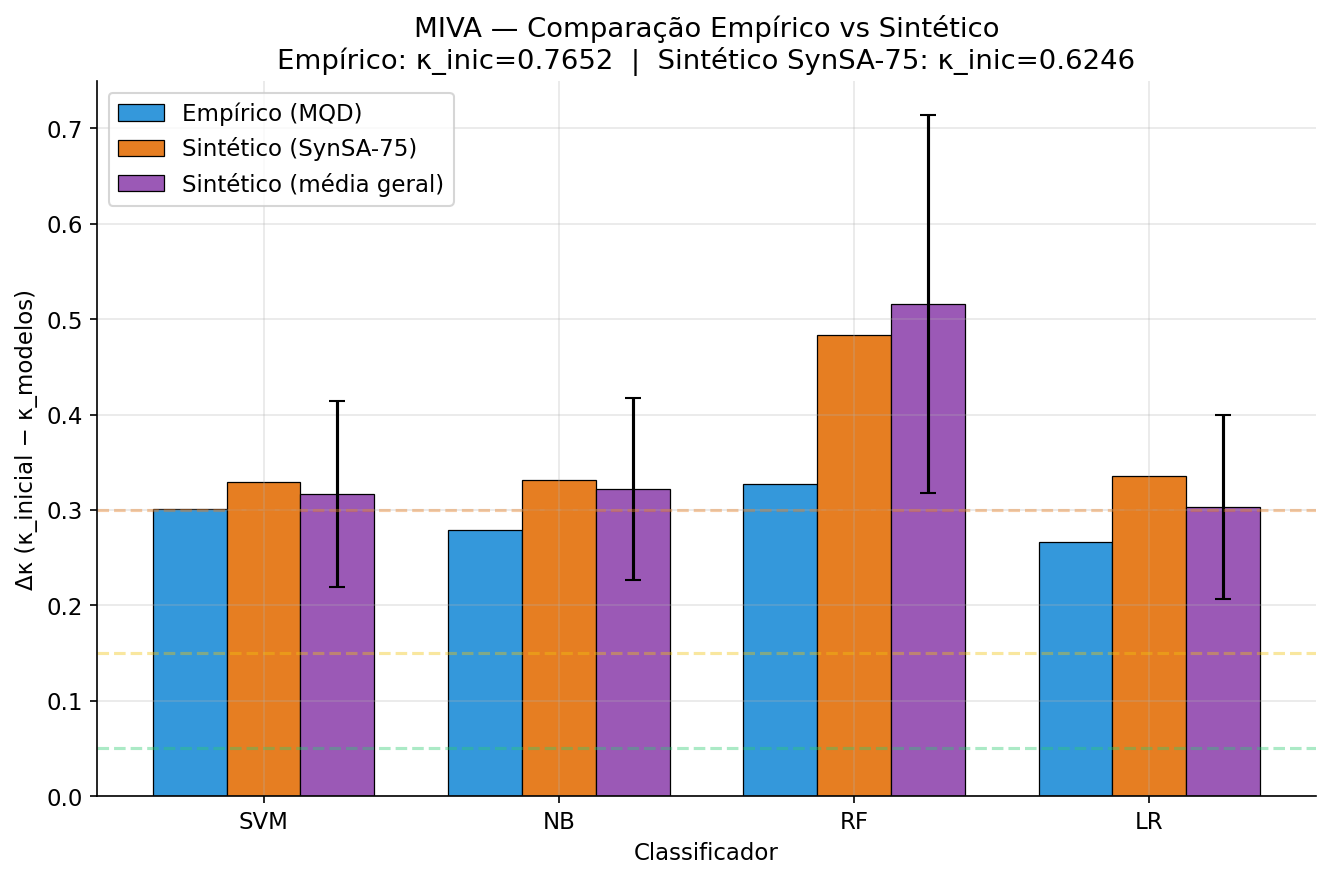

✔ Gráfico salvo: grafico4_comparacao_empirico_sintetico.png


In [14]:
# =============================================================================
# GRÁFICO 4: Comparação Empírico vs Sintético (Δκ médio por modelo)
# =============================================================================

# Δκ empírico
dk_emp = df_miva_emp.set_index('modelo')['delta_kappa']

# Δκ médio sintético (média sobre todos os datasets)
dk_sint_mean = df_miva_sint.groupby('modelo')['delta_kappa'].mean()
dk_sint_std = df_miva_sint.groupby('modelo')['delta_kappa'].std()

# Δκ sintético no ponto mais próximo da concordância real (~76.5%)
# O dataset SynSA-75 (concordância-alvo 75%) é o mais próximo
df_sint_75 = df_miva_sint[df_miva_sint['concordancia_alvo'] == 75]
dk_sint_75 = df_sint_75.set_index('modelo')['delta_kappa']

fig, ax = plt.subplots(figsize=(9, 6))

x = np.arange(len(MODELOS))
largura = 0.25

bars1 = ax.bar(x - largura, [dk_emp.get(m, 0) for m in MODELOS],
               largura, label='Empírico (MQD)', color='#3498db', edgecolor='black', linewidth=0.6)

bars2 = ax.bar(x, [dk_sint_75.get(m, 0) for m in MODELOS],
               largura, label='Sintético (SynSA-75)', color='#e67e22', edgecolor='black', linewidth=0.6)

bars3 = ax.bar(x + largura, [dk_sint_mean.get(m, 0) for m in MODELOS],
               largura, label='Sintético (média geral)',
               yerr=[dk_sint_std.get(m, 0) for m in MODELOS],
               capsize=4, color='#9b59b6', edgecolor='black', linewidth=0.6)

# Limiares
ax.axhline(y=0.05, color='#2ecc71', linestyle='--', alpha=0.4)
ax.axhline(y=0.15, color='#f1c40f', linestyle='--', alpha=0.4)
ax.axhline(y=0.30, color='#e67e22', linestyle='--', alpha=0.4)

ax.set_xticks(x)
ax.set_xticklabels(MODELOS)
ax.set_ylabel('Δκ (κ_inicial − κ_modelos)')
ax.set_xlabel('Classificador')
ax.set_title('MIVA — Comparação Empírico vs Sintético\n'
             f'Empírico: κ_inic={KAPPA_ANOTADORES_EMPIRICO}  |  '
             f'Sintético SynSA-75: κ_inic={kappa_inicial_por_dataset.get("SynSA-75", "N/A"):.4f}')
ax.legend(loc='upper left')

plt.tight_layout()
fig.savefig(PATH_SAIDA / 'grafico4_comparacao_empirico_sintetico.png', bbox_inches='tight')
plt.show()
print("✔ Gráfico salvo: grafico4_comparacao_empirico_sintetico.png")

### 3.5 Gráfico 5 — Curvas de Amplificação: Δκ em função da concordância

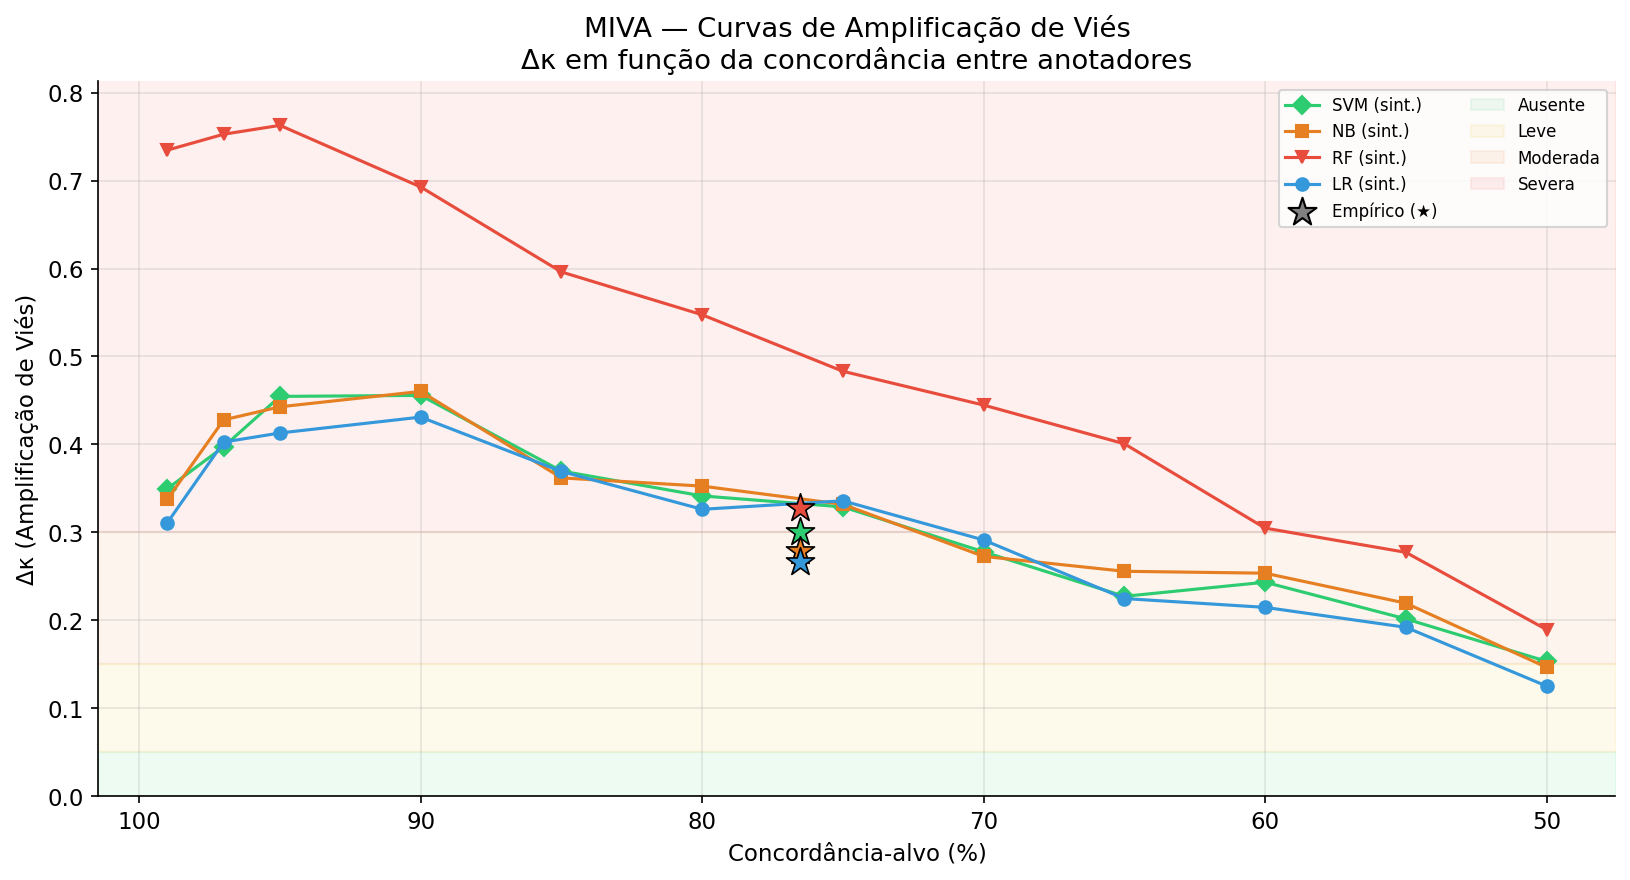

✔ Gráfico salvo: grafico5_curvas_amplificacao.png


In [15]:
# =============================================================================
# GRÁFICO 5: Curvas de Δκ em função da concordância (com ponto empírico)
# =============================================================================

fig, ax = plt.subplots(figsize=(11, 6))

for modelo in MODELOS:
    df_mod = df_miva_sint[df_miva_sint['modelo'] == modelo].sort_values(
        'concordancia_alvo', ascending=False)
    marcador, cor = estilos[modelo]
    ax.plot(df_mod['concordancia_alvo'], df_mod['delta_kappa'],
            f'-{marcador}', color=cor, linewidth=1.5, markersize=6, label=f'{modelo} (sint.)')

# Pontos empíricos (plotados na posição da concordância real)
conc_real_pct = KAPPA_ANOTADORES_EMPIRICO * 100  # Aproximação para o eixo X
for modelo in MODELOS:
    dk_val = dk_emp.get(modelo, 0)
    marcador, cor = estilos[modelo]
    ax.scatter(conc_real_pct, dk_val, marker='*', s=200, color=cor,
               edgecolors='black', linewidths=0.8, zorder=10)

# Legenda auxiliar para os pontos empíricos
ax.scatter([], [], marker='*', s=200, color='gray', edgecolors='black',
           label='Empírico (★)')

# Faixas de severidade
ax.axhspan(0, 0.05, alpha=0.08, color='#2ecc71', label='Ausente')
ax.axhspan(0.05, 0.15, alpha=0.08, color='#f1c40f', label='Leve')
ax.axhspan(0.15, 0.30, alpha=0.08, color='#e67e22', label='Moderada')
ax.axhspan(0.30, 1.0, alpha=0.08, color='#e74c3c', label='Severa')

ax.set_xlabel('Concordância-alvo (%)')
ax.set_ylabel('Δκ (Amplificação de Viés)')
ax.set_title('MIVA — Curvas de Amplificação de Viés\n'
             'Δκ em função da concordância entre anotadores')
ax.legend(loc='upper right', fontsize=8, ncol=2)
ax.invert_xaxis()
ax.set_ylim(0, max(df_miva_sint['delta_kappa'].max(), dk_emp.max()) + 0.05)

plt.tight_layout()
fig.savefig(PATH_SAIDA / 'grafico5_curvas_amplificacao.png', bbox_inches='tight')
plt.show()
print("✔ Gráfico salvo: grafico5_curvas_amplificacao.png")

### 3.6 Gráfico 6 — Cramér's V: Força de Associação (Sintético)

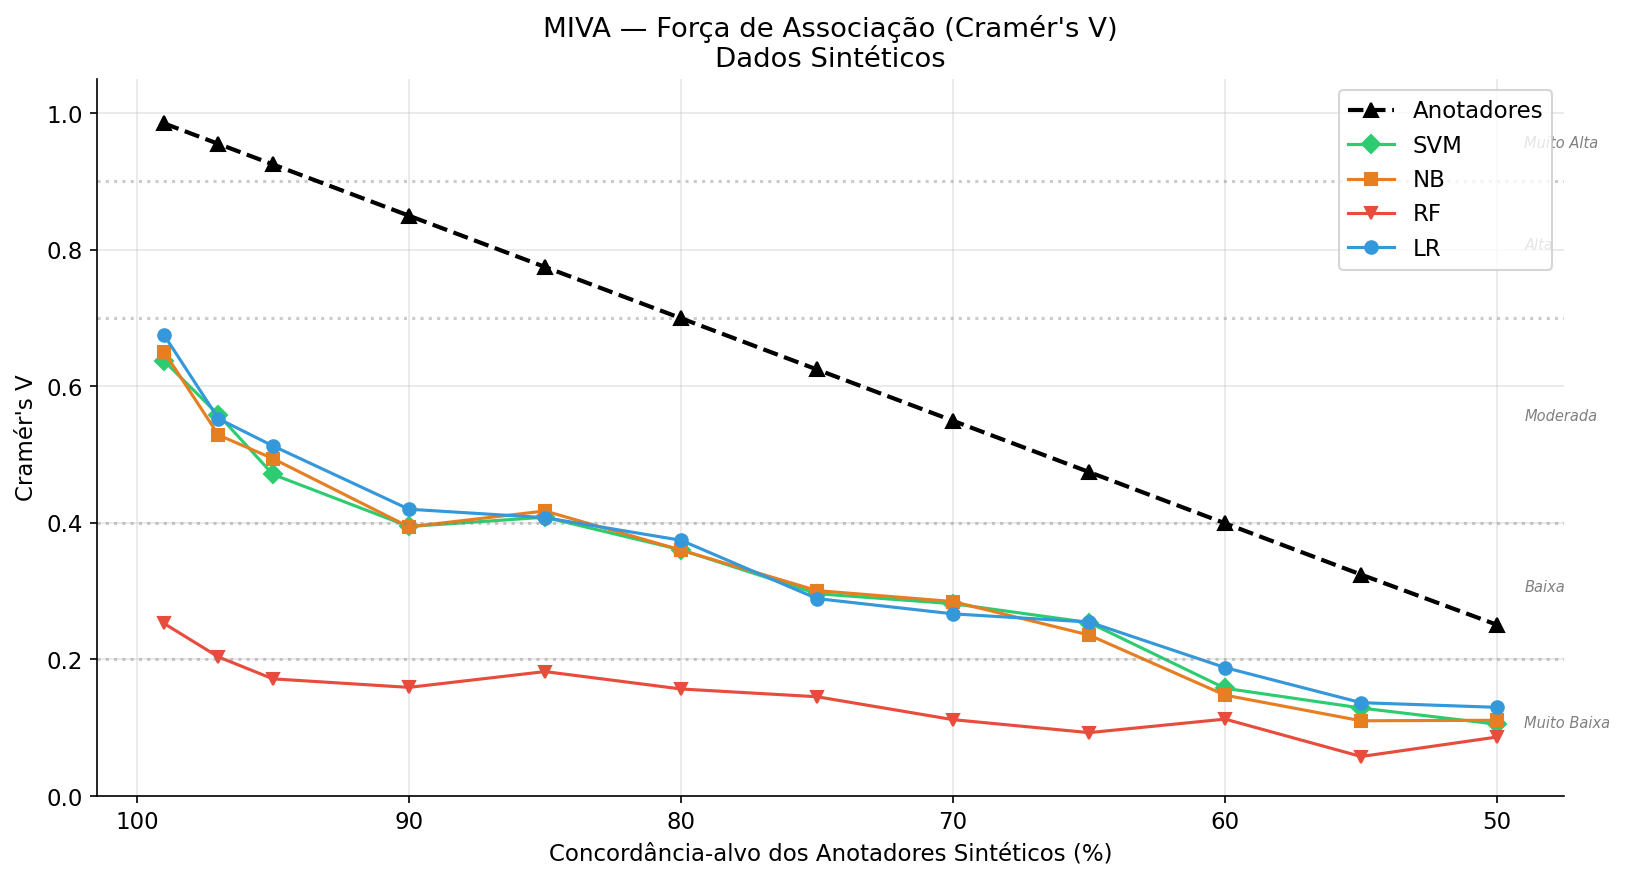

✔ Gráfico salvo: grafico6_cramers_v_sintetico.png


In [16]:
# =============================================================================
# GRÁFICO 6: Cramér's V em função da concordância
# =============================================================================

fig, ax = plt.subplots(figsize=(11, 6))

# Curva Anotadores
df_anot_sorted = df_anot.sort_values('concordancia_alvo', ascending=False)
ax.plot(df_anot_sorted['concordancia_alvo'], df_anot_sorted['cramers_v'],
        'k--^', linewidth=2, markersize=7, label='Anotadores', zorder=5)

for modelo in MODELOS:
    df_mod = df_modelos[df_modelos['fonte'] == modelo].sort_values(
        'concordancia_alvo', ascending=False)
    marcador, cor = estilos[modelo]
    ax.plot(df_mod['concordancia_alvo'], df_mod['cramers_v'],
            f'-{marcador}', color=cor, linewidth=1.5, markersize=6, label=modelo)

# Faixas de interpretação de Cramér's V (Alan & Duncan 1997)
ax.axhline(y=0.20, color='gray', linestyle=':', alpha=0.4)
ax.axhline(y=0.40, color='gray', linestyle=':', alpha=0.4)
ax.axhline(y=0.70, color='gray', linestyle=':', alpha=0.4)
ax.axhline(y=0.90, color='gray', linestyle=':', alpha=0.4)

# Rótulos das faixas à direita
ax.text(49, 0.10, 'Muito Baixa', fontsize=7, color='gray', style='italic')
ax.text(49, 0.30, 'Baixa', fontsize=7, color='gray', style='italic')
ax.text(49, 0.55, 'Moderada', fontsize=7, color='gray', style='italic')
ax.text(49, 0.80, 'Alta', fontsize=7, color='gray', style='italic')
ax.text(49, 0.95, 'Muito Alta', fontsize=7, color='gray', style='italic')

ax.set_xlabel('Concordância-alvo dos Anotadores Sintéticos (%)')
ax.set_ylabel("Cramér's V")
ax.set_title("MIVA — Força de Associação (Cramér's V)\nDados Sintéticos")
ax.legend(loc='upper right')
ax.invert_xaxis()
ax.set_ylim(0, 1.05)

plt.tight_layout()
fig.savefig(PATH_SAIDA / 'grafico6_cramers_v_sintetico.png', bbox_inches='tight')
plt.show()
print("✔ Gráfico salvo: grafico6_cramers_v_sintetico.png")

## 4. Relatório Final de Severidade
---

In [17]:
# =============================================================================
# RELATÓRIO FINAL DE SEVERIDADE
# =============================================================================

print("="*80)
print("RELATÓRIO MIVA — QUANTIFICAÇÃO DA AMPLIFICAÇÃO DE VIÉS")
print("="*80)

# --- Empírico ---
print("\n" + "-"*40)
print("DADOS EMPÍRICOS (MQD-1465)")
print("-"*40)
print(f"κ_inicial (Anotadores): {KAPPA_ANOTADORES_EMPIRICO}")
print()
for _, row in df_miva_emp.iterrows():
    print(f"  {row['modelo']:>4s}: κ_modelos = {row['kappa_modelos']:.4f}  |  "
          f"Δκ = {row['delta_kappa']:.4f}  |  "
          f"Severidade: {row['severidade']}")

# --- Sintético: resumo ---
print("\n" + "-"*40)
print("DADOS SINTÉTICOS (SynSA-99 a SynSA-50)")
print("-"*40)

for ds in ordem_ds:
    df_ds = df_miva_sint[df_miva_sint['dataset'] == ds]
    conc = df_ds['concordancia_alvo'].iloc[0]
    ki = df_ds['kappa_inicial'].iloc[0]
    print(f"\n  {ds} (concordância={conc}%, κ_inicial={ki:.4f}):")
    for _, row in df_ds.iterrows():
        print(f"    {row['modelo']:>4s}: κ={row['kappa_modelos']:.4f}  "
              f"Δκ={row['delta_kappa']:.4f}  [{row['severidade']}]")

# --- Resumo Geral ---
print("\n" + "="*80)
print("RESUMO GERAL")
print("="*80)

for sev in ['Ausente', 'Leve', 'Moderada', 'Severa']:
    n = (df_unificado['severidade'] == sev).sum()
    pct = 100 * n / len(df_unificado)
    print(f"  {sev:>10s}: {n:>3d} ocorrências ({pct:.1f}%)")

print(f"\nTotal de comparações: {len(df_unificado)}")

# Modelo com maior amplificação média
pior = df_unificado.groupby('modelo')['delta_kappa'].mean().idxmax()
melhor = df_unificado.groupby('modelo')['delta_kappa'].mean().idxmin()
print(f"\nModelo com MAIOR amplificação média: {pior} "
      f"(Δκ médio = {df_unificado.groupby('modelo')['delta_kappa'].mean()[pior]:.4f})")
print(f"Modelo com MENOR amplificação média: {melhor} "
      f"(Δκ médio = {df_unificado.groupby('modelo')['delta_kappa'].mean()[melhor]:.4f})")

print("\n" + "="*80)
print("✔ ANÁLISE MIVA CONCLUÍDA")
print("="*80)

RELATÓRIO MIVA — QUANTIFICAÇÃO DA AMPLIFICAÇÃO DE VIÉS

----------------------------------------
DADOS EMPÍRICOS (MQD-1465)
----------------------------------------
κ_inicial (Anotadores): 0.7652

   SVM: κ_modelos = 0.4647  |  Δκ = 0.3005  |  Severidade: Severa
    NB: κ_modelos = 0.4862  |  Δκ = 0.2790  |  Severidade: Moderada
    RF: κ_modelos = 0.4378  |  Δκ = 0.3274  |  Severidade: Severa
    LR: κ_modelos = 0.4986  |  Δκ = 0.2666  |  Severidade: Moderada

----------------------------------------
DADOS SINTÉTICOS (SynSA-99 a SynSA-50)
----------------------------------------

  SynSA-99 (concordância=99%, κ_inicial=0.9850):
     SVM: κ=0.6354  Δκ=0.3496  [Severa]
      NB: κ=0.6475  Δκ=0.3375  [Severa]
      RF: κ=0.2503  Δκ=0.7347  [Severa]
      LR: κ=0.6740  Δκ=0.3109  [Severa]

  SynSA-97 (concordância=97%, κ_inicial=0.9550):
     SVM: κ=0.5576  Δκ=0.3974  [Severa]
      NB: κ=0.5271  Δκ=0.4279  [Severa]
      RF: κ=0.2022  Δκ=0.7527  [Severa]
      LR: κ=0.5524  Δκ=0.4026  [S

In [18]:
# =============================================================================
# LISTAGEM DOS ARQUIVOS GERADOS
# =============================================================================

print("Arquivos gerados em resultados_gerais/:")
for f in sorted(PATH_SAIDA.glob('*')):
    tamanho = f.stat().st_size
    print(f"  {f.name:50s} ({tamanho:>8,d} bytes)")

Arquivos gerados em resultados_gerais/:
  grafico1_delta_kappa_empirico.png                  (  71,288 bytes)
  grafico2_curvas_kappa_sintetico.png                ( 137,517 bytes)
  grafico3_heatmap_severidade_sintetico.png          ( 154,840 bytes)
  grafico4_comparacao_empirico_sintetico.png         (  66,410 bytes)
  grafico5_curvas_amplificacao.png                   ( 131,484 bytes)
  grafico6_cramers_v_sintetico.png                   ( 128,476 bytes)
  resumo_miva_empirico.csv                           (     718 bytes)
  resumo_miva_sintetico.csv                          (   8,295 bytes)
  resumo_miva_unificado.csv                          (   4,695 bytes)
